In [1]:
using RCall

In [2]:
R"require(cvxbiclustr)"
R"data(lung)"
R"lung = as.matrix(lung)"
lung = (@rget lung);

Loading required package: Matrix
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



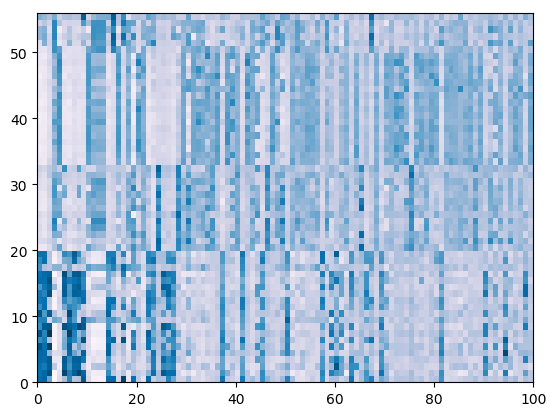

PyObject <matplotlib.collections.QuadMesh object at 0x1479f5a10>

In [3]:
using PyPlot
n,m = size(lung);
X = lung - repmat(mean(lung,1),n,1);
X = X./vecnorm(X);
pcolormesh(X',cmap = "PuBu")

In [8]:
function update_q(Theta,sigma,v0)
    n = size(Theta,1);
    diff_sq = reshape(sum((repeat(Theta,outer = [n,1]) - repeat(Theta,inner = [n,1])).^2,2),n,n);
    Q = exp.(-diff_sq/v0/sigma^2);
    Q = Q./ sum(Q,2);
    return Q * Diagonal(1./sum(Q,1)[:]) * Q';
end

update_q (generic function with 1 method)

In [12]:
function bayes_bch(Y; v0 = 1e-1, sigma = 0.1, iter = 100)
    
    # initialize
    n,m = size(Y);
    Theta = Y + 0.001 * sigma * randn(n,m);
    # loop start
    for i = 1:iter
        L_r = update_q(Theta,sigma,v0);
        L_c = update_q(Theta',sigma,v0);
        L = sparse(kron(L_r,speye(m))) + sparse(kron(speye(n), L_c));
        Theta = reshape((speye(n*m) + L/v0)\Y[:],n,m);
    end
    return Theta
end

bayes_bch (generic function with 1 method)

In [16]:
out = bayes_bch(X, v0 = 1e-1, iter = 1);

In [45]:
function one_step_update(Theta,Mu,sigma,v0; transposed = false)
    n = size(Theta,1); k = size(Mu,1);
    diff_sq = reshape(sum((repeat(Theta,outer = [k,1]) - repeat(Mu,inner = [n,1])).^2,2),n,k);
    Q = exp.(-diff_sq/(v0*sigma^2));
    Q = Q./ sum(Q,2);
    R = Diagonal(1./sum(Q,1)[:]) * Q';
    L = Q * R;
    Mu = R * Theta;
    if transposed == false
        return Mu, L
    else
        return Mu', L
    end
end

one_step_update (generic function with 2 methods)

In [27]:
function update_theta(Y,L_r,L_c,v0)
    n,m = size(Y);
    L = sparse(kron(L_r,speye(m))) + sparse(kron(speye(n), L_c));
    Theta = reshape((speye(n*m) + L/v0)\Y[:],n,m);
end

update_theta (generic function with 1 method)

In [48]:
function bayes_biclust_hidden(Y; v0 = 1e-1, sigma = 1, iter = 100, k1 = 2, k2 = 2)
    
    # initialize
    n1,n2 = size(Y);
    Theta = Y + 1e-4 * randn(n1,n2);
    S1 = randperm(n1)[1:k1];
    S2 = randperm(n2)[1:k2];
    Mu1 = Y[S1,:] + 1e-4 * randn(k1,n2);
    Mu2 = Y[:,S2] + 1e-4 * randn(n1,k2);
    
    # loop start
    for i = 1:iter
        Mu1, L1 = one_step_update(Theta,Mu1,sigma,v0);
        Mu2, L2 = one_step_update(Theta',Mu2',sigma,v0, transposed = true);
        Theta = update_theta(Y,L1,L2,v0);
    end
    return Theta, Mu1, Mu2
end

bayes_biclust_hidden (generic function with 1 method)

In [78]:
out = bayes_biclust_hidden(Y, iter = 20);
pcolormesh(out[1]', cmap = "PuBu")

LoadError: [91mInterruptException:[39m

In [68]:
function bayes(Y; v0 = 1e-1, sigma = 1, iter = 1000, k1 = 2, k2 = 2)
    
    function update(Y,Theta,Mu,sigma,v0; transposed = false)
    n = size(Y,1); k = size(Mu,1);
    diff_sq = reshape(sum((repeat(Theta,outer = [k,1]) - repeat(Mu,inner = [n,1])).^2,2),n,k);
    Q = exp.(-diff_sq/(v0*sigma^2));
    Q = Q./ sum(Q,2);
    R = Diagonal(1./sum(Q,1)[:]) * Q';
    Theta = (eye(n) + (eye(n) - Q * R)/v0)\Y;
    Mu = R * Theta;
    if transposed == false return Theta, Mu
    else return Theta', Mu'
    end
    end
    
    # initialize
    n1,n2 = size(Y);
    Theta = Y + 0.001 * randn(n1,n2);
    S1 = randperm(n)[1:k1];
    S2 = randperm(m)[1:k2];
    Mu1 = Y[S1,:] + 0.001 * randn(k1,n2);
    Mu2 = Y[:,S2] + 0.001 * randn(n1,k2);
    
    # loop start
    for i = 1:iter
        Theta, Mu1 = update(Y,Theta,Mu1,sigma,v0);
        Theta, Mu2 = update(Y',Theta',Mu2',sigma,v0, transposed = true);
    end
    return Theta, Mu1, Mu2
end

bayes (generic function with 1 method)

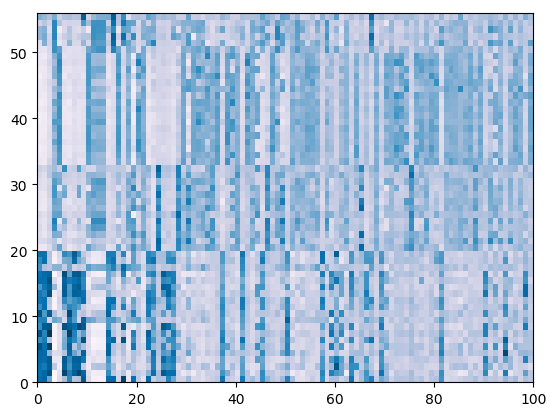

PyObject <matplotlib.collections.QuadMesh object at 0x14fb80b10>

In [74]:
res = bayes(X, v0 = 1e-2, k1 = 5, k2 = 5);
pcolormesh(res[1]',cmap = "PuBu")

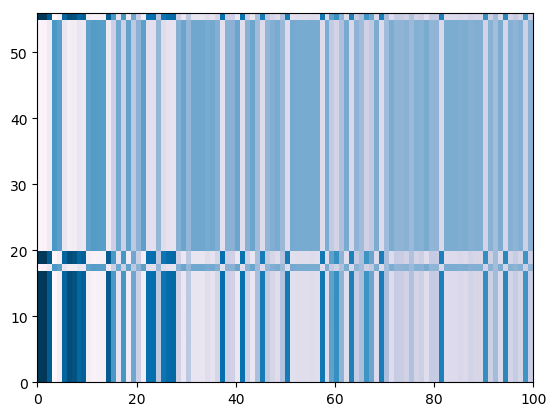

PyObject <matplotlib.collections.QuadMesh object at 0x15296b6d0>

In [72]:
pcolormesh(res[1]',cmap = "PuBu")

In [439]:
function bayes_rowclust(Y;v0 = 1e-1, v1 = 1e4, sigma = 1, iter = 100)
    n,m = size(Y);
    Theta = Y + 0.01 * randn(n,m);
    Q = zeros(n,n);
    for i = 1:iter
        diff_sq = reshape(sum((repeat(Theta,outer = [n,1]) - repeat(Theta,inner = [n,1])).^2,2),n,n);
        Q = 1./ (1 + sqrt(v0/v1) * exp.(diff_sq/sigma^2 * (1/v0 - 1/v1)));
        R = Q/v0 + (1-Q)/v1;
        Theta = (eye(n) + (Diagonal(sum(R,2)[:]) - R))\Y;
    end
    return Theta, Q
end

bayes_rowclust (generic function with 1 method)

In [75]:
function bayes_rowclust_hidden(Y;v0 = 1e-1, sigma = 1, iter = 1000, k = 2)
    n,m = size(Y);
    Theta = Y + 0.0 * randn(n,m);
    S = randperm(n)[1:k];
    Mu = Y[S,:] + 0.0 * randn(k,m);
    Q = zeros(n,n);
    for i = 1:iter
        diff_sq = reshape(sum((repeat(Theta,outer = [k,1]) - repeat(Mu,inner = [n,1])).^2,2),n,k);
    #    Q = 1./ (1 + sqrt(v0/v1) * exp.(diff_sq/sigma^2 * (1/v0 - 1/v1)));
        Q = exp.(-diff_sq/(v0*sigma^2));
        Q = Q./ sum(Q,2);
        R = Diagonal(1./sum(Q,1)[:]) * Q';
        Theta = (eye(n) + (eye(n) - Q * R)/v0)\Y;
        Mu = R * Theta;
    end
    return Theta, Mu, Q
end

bayes_rowclust_hidden (generic function with 1 method)

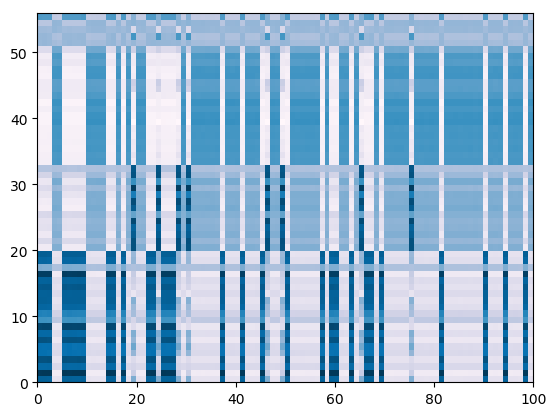

PyObject <matplotlib.collections.QuadMesh object at 0x14d5da390>

In [77]:
out = bayes_rowclust_hidden(X * 10,v0 = 1e-2, sigma = 1, k = 5);
pcolormesh(out[1]',cmap = "PuBu")

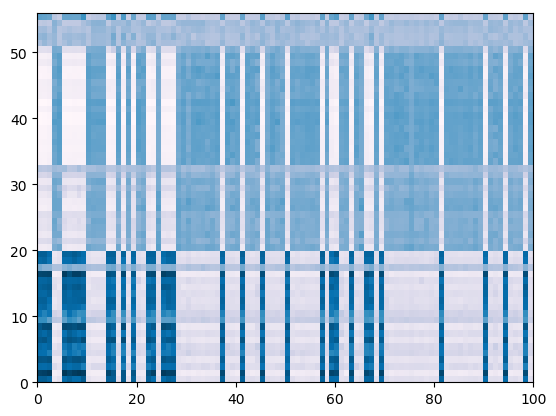

PyObject <matplotlib.collections.QuadMesh object at 0x14d8d2f90>

In [79]:
out2 = bayes_rowclust_hidden(X * 10,v0 = 1e-1, sigma = 1, k = 5);
pcolormesh(out2[1]',cmap = "PuBu")

In [81]:
kron([1 2; 3 4], eye(3))

6×6 Array{Float64,2}:
 1.0  0.0  0.0  2.0  0.0  0.0
 0.0  1.0  0.0  0.0  2.0  0.0
 0.0  0.0  1.0  0.0  0.0  2.0
 3.0  0.0  0.0  4.0  0.0  0.0
 0.0  3.0  0.0  0.0  4.0  0.0
 0.0  0.0  3.0  0.0  0.0  4.0

In [88]:
A = [1 0 0; 2 3 4]'

3×2 Array{Int64,2}:
 1  2
 0  3
 0  4

In [89]:
reshape(kron([1 2; 3 4], eye(3)) * A[:],3,2)

3×2 Array{Float64,2}:
 5.0  11.0
 6.0  12.0
 8.0  16.0

In [90]:
A * [1 2; 3 4]'

3×2 Array{Int64,2}:
 5  11
 6  12
 8  16